# WINE QUALITY - IMBALANCE HANDLING

**Purpose:** This notebook demonstrates how to build and evaluate a binary classification model on the Wine Quality dataset.

**Contents:**
- Data import (pre-cleaned and scaled)
- Train-test split and visualization
- Baseline model training and evaluation
- Imbalance handling using:
  1. **SMOTE (Synthetic Minority Oversampling Technique)**
  2. **Class Weight Adjustment**
  3. **Random Undersampling**
- Performance comparison using **Accuracy, Precision, Recall, F1-score, and AUC**
- Visualization of results and conclusions.


**Note:** This is an **imbalanced classification problem**.
Given this imbalance, **Accuracy** is not a reliable metric. We will focus on **Precision, Recall, F1-score (for the minority class 1), and AUC**.


## 1. Overview: Handling Imbalanced Data

### 1.1. What is Imbalanced Data?

**Imbalanced Data** is a common problem in classification where the number of observations per class is not equally distributed. One class (the **majority class**) significantly outnumbers the other class (the **minority class**).

This is prevalent in many real-world scenarios, such as:
* Fraud Detection (fraudulent transactions are rare)
* Medical Diagnosis (presence of a rare disease)
* Customer Churn (customers who leave are a minority)

In our wine dataset, the "Good" quality wine (Class 1) is the minority class, and "Not Good" (Class 0) is the majority class.

### 1.2. The Problem with Imbalance

Most machine learning algorithms are designed to maximize overall **accuracy**. When faced with imbalanced data, a model can achieve high accuracy by simply "giving up" on the minority class and always predicting the majority class.

> **The Accuracy Paradox:**
> Imagine a dataset with 95% Class 0 and 5% Class 1. A lazy model that predicts "Class 0" every single time will still have 95% accuracy. While this score seems high, the model is completely useless because it fails to identify *any* of the Class 1 instances we actually care about.

Because of this, accuracy is a misleading metric. We must use more nuanced evaluation metrics.

### 1.3. Key Evaluation Metrics

To understand model performance on imbalanced data, we use a **Confusion Matrix**.



* **True Positives (TP):** Correctly predicted as Class 1.
* **True Negatives (TN):** Correctly predicted as Class 0.
* **False Positives (FP):** Incorrectly predicted as Class 1 (a "false alarm").
* **False Negatives (FN):** Incorrectly predicted as Class 0 (a "miss").

From this, we derive the following crucial metrics:

* **Precision:**
    * *Question:* Of all the predictions for Class 1, how many were correct?
    * *Formula:* $$\text{Precision} = \frac{TP}{TP + FP}$$
    * *Use Case:* High precision is critical when the cost of a **False Positive** is high (e.g., falsely flagging a good bank transaction as fraud).

* **Recall (True Positive Rate):**
    * *Question:* Of all the *actual* Class 1 instances, how many did the model find?
    * *Formula:* $$\text{Recall} = \frac{TP}{TP + FN}$$
    * *Use Case:* High recall is critical when the cost of a **False Negative** is high (e.g., failing to detect a serious disease).

* **F1-Score:**
    * The harmonic mean of Precision and Recall. It provides a single score that balances both concerns. It is generally more useful than accuracy on imbalanced datasets.
    * *Formula:* $$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

* **ROC-AUC (Area Under the Receiver Operating Characteristic Curve):**
    * This metric evaluates the model's overall ability to *discriminate* between the two classes, regardless of the classification threshold.
    * An AUC of 1.0 is a perfect classifier.
    * An AUC of 0.5 is no better than random guessing.
    
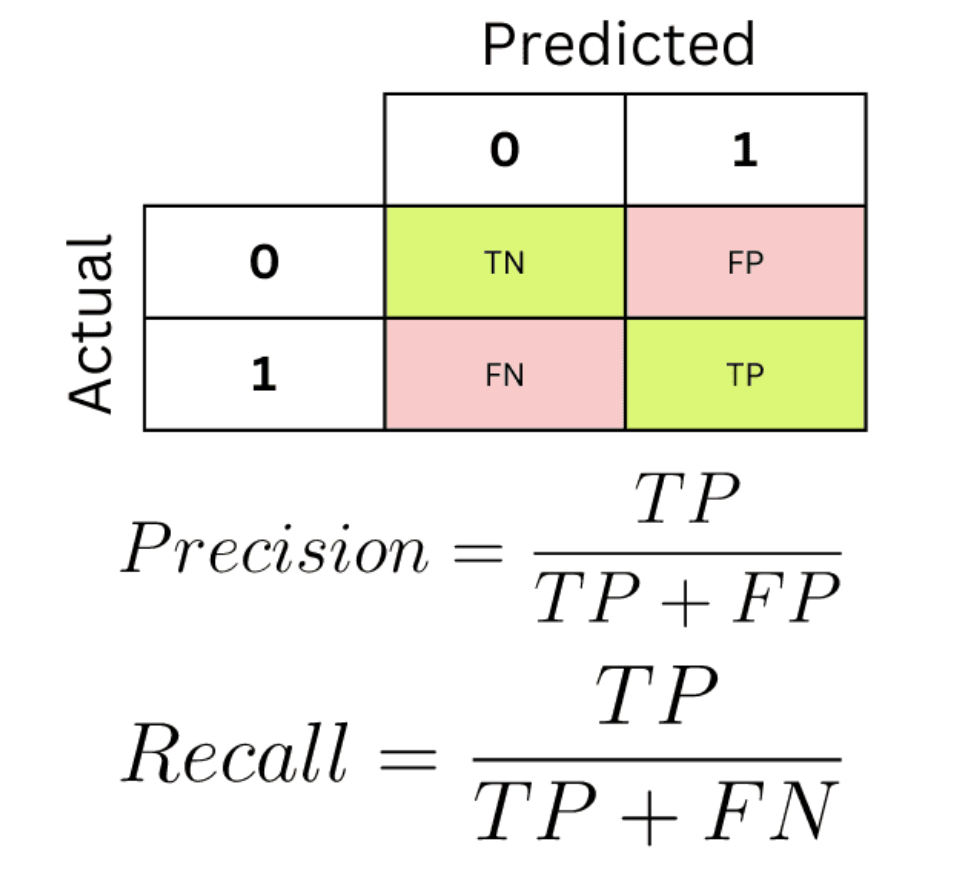

### 1.4. Imbalance Handling Techniques

We will explore three primary strategies in this notebook.

#### 1. Data-Level Methods (Resampling)

This approach involves modifying the training data to make it balanced.

* **Oversampling:**
    * **Goal:** Increase the number of minority class samples.
    * **Technique 1: Random Oversampling.** This simply duplicates random samples from the minority class. It is fast but can lead to **overfitting**, as the model learns to recognize specific minority samples.
    * **Technique 2: SMOTE (Synthetic Minority Oversampling Technique).** This is a more intelligent approach.
        1.  It selects a minority class sample.
        2.  It finds its *k-nearest neighbors* (also from the minority class).
        3.  It creates a new "synthetic" sample at a random point along the line segment connecting the original sample and one of its neighbors.
        4.  This creates *new*, plausible minority samples rather than just copies.
    

* **Undersampling:**
    * **Goal:** Decrease the number of majority class samples.
    * **Technique: Random Undersampling.** This randomly removes samples from the majority class until the dataset is balanced.
    * **Pros:** Can significantly speed up model training time.
    * **Cons:** Can lead to **significant information loss** from the majority class, potentially causing the model to miss important patterns.

#### 2. Algorithm-Level Methods (Cost-Sensitive Learning)

This approach modifies the model's algorithm to pay more attention to the minority class.

* **Technique: Class Weight Balancing:**
    * **Goal:** Penalize misclassifications of the minority class more heavily than misclassifications of the majority class.
    * **How it works:** We assign a higher "weight" to the minority class. Most `scikit-learn` classifiers (like `RandomForest` and `LogisticRegression`) support this via the `class_weight='balanced'` parameter.
    * The "balanced" mode automatically calculates weights inversely proportional to the class frequencies:
  $$ w_j = \frac{n_{\text{samples}}}{ (n_{\text{classes}} \times n_{\text{samples}, j})} $$
  Where $ w_j $ is the weight for class $j$, $n_{\text{samples}}$ is the total number of samples, and $n_{\text{samples}, j}$ is the number of samples in class $j$.

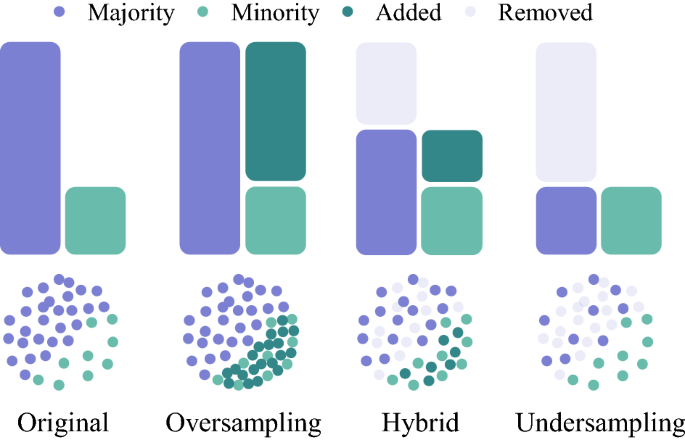

## 2. Surpress warnings and Import necessary libraries

Suppress warnings for cleaner output and import required libraries:
- `numpy`, `pandas`: For data manipulation.
- `matplotlib`, `seaborn`: For visualization.
- `sklearn`, `imblearn`: For machine learning models and handling imbalanced data.

In [ ]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Machine Learning models
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, ConfusionMatrixDisplay,recall_score, precision_score, accuracy_score

# Libraries for hadling imbalanced data
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


## 3. Load and Explore Dataset

Load the preprocessed dataset `Wine_clean.csv` and perform initial checks.

### 3.1 Basic Information
- Display shape, head, info, and descriptive statistics.

### 3.2 Distributions
- Create binary target.
- Check feature distributions and target imbalance.
- Visualize target distribution to frame the task (binary classification).

In [ ]:
# Load the dataset (assumed already cleaned and scaled)
df = pd.read_csv('Data/Wine_clean.csv')
# Drop column Unnamed:0 if exits
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

In [ ]:
# Show top rows and basic info
print('Shape:', df.shape)
display(df.head())
display(df.info())
display(df.describe())

Shape: (1194, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5
1,-0.250994,2.167738,-1.377452,0.937243,1.365747,1.133715,0.952872,0.142508,-0.938945,0.411596,-0.579638,5
2,-0.250994,1.439628,-1.155393,0.258471,0.946004,-0.000665,0.454289,0.267217,-0.484660,0.153303,-0.579638,5
3,2.076938,-1.472812,1.731370,-0.646558,-0.243268,0.226211,0.684404,0.890766,-1.241802,-0.449381,-0.579638,6
4,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1194 non-null   float64
 1   volatile acidity      1194 non-null   float64
 2   citric acid           1194 non-null   float64
 3   residual sugar        1194 non-null   float64
 4   chlorides             1194 non-null   float64
 5   free sulfur dioxide   1194 non-null   float64
 6   total sulfur dioxide  1194 non-null   float64
 7   density               1194 non-null   float64
 8   pH                    1194 non-null   float64
 9   sulphates             1194 non-null   float64
 10  alcohol               1194 non-null   float64
 11  quality               1194 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 112.1 KB


None

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1.194000e+03,1194.000000
mean,4.284680e-16,-9.521511e-17,7.141133e-17,-2.856453e-16,-1.904302e-16,-5.950944e-17,1.071170e-16,7.236348e-15,3.511057e-16,-6.188982e-16,1.737676e-15,5.640704
std,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,1.000419e+00,0.766471
min,-2.099646e+00,-2.443625e+00,-1.377452e+00,-2.230359e+00,-2.621812e+00,-1.588798e+00,-1.386636e+00,-2.632285e+00,-2.907515e+00,-2.601823e+00,-1.707596e+00,3.000000
25%,-7.302743e-01,-8.053775e-01,-9.333346e-01,-6.465576e-01,-6.630112e-01,-7.947313e-01,-7.729942e-01,-6.665470e-01,-7.118025e-01,-7.076739e-01,-8.872630e-01,5.000000
50%,-2.509942e-01,-1.659184e-02,-4.509986e-02,-1.940431e-01,-3.339664e-02,-2.275411e-01,-2.360579e-01,1.779778e-02,7.482646e-03,-1.910878e-01,-2.720131e-01,6.000000
75%,5.706289e-01,6.508422e-01,7.876203e-01,7.109860e-01,5.962179e-01,5.665251e-01,5.214057e-01,6.382288e-01,6.321250e-01,5.837913e-01,6.508618e-01,6.000000
max,2.830092e+00,2.926185e+00,2.675119e+00,3.199816e+00,2.834848e+00,3.062162e+00,3.062265e+00,2.761413e+00,2.695338e+00,2.994526e+00,3.111862e+00,8.000000


Class distribution:
 label
0    1047
1     147
Name: count, dtype: int64


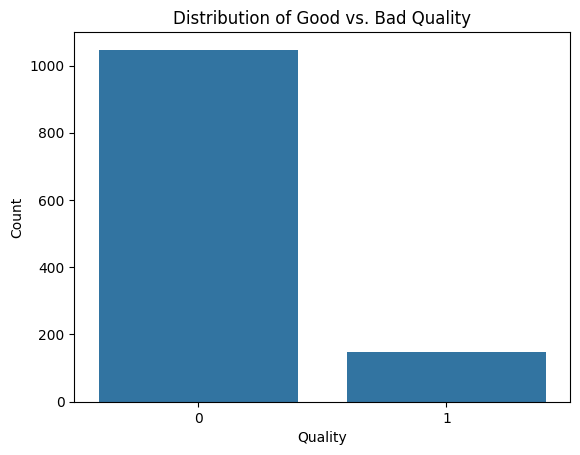

In [ ]:
# Create binary target and visualize imbalance
# Create binary target
df['label'] = (df['quality'] >= 7).astype(int)

# Drop the original quality column
X = df.drop(columns=['quality', 'label'])
y = df['label']

# Check imbalance
print("Class distribution:\n", y.value_counts())

# Visualize class imbalance
sns.countplot(x=y)
plt.title("Distribution of Good vs. Bad Quality")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

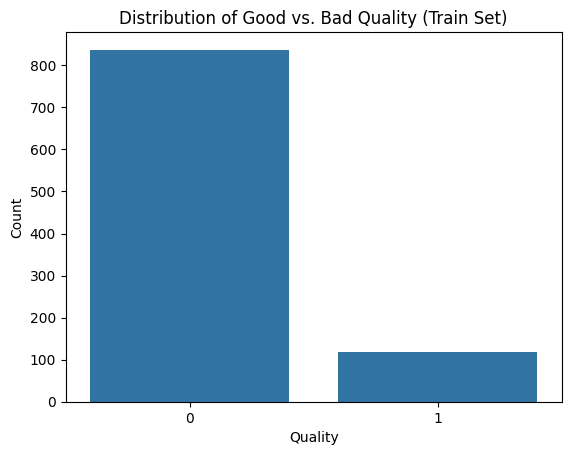

In [ ]:
# Split data and visualize train set imbalance
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Visualize class imbalance in train set
sns.countplot(x=y_train)
plt.title("Distribution of Good vs. Bad Quality (Train Set)")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

In [ ]:
# Define evaluation functions
# Function for evaluating model
def evaluate_model(y_true, y_pred, y_proba):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, y_proba)
    acc = np.mean(y_true == y_pred)
    return {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }

# Function for printing report
def print_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Baseline Metrics: {'Accuracy': np.float64(0.9246861924686193), 'Precision': 0.7894736842105263, 'Recall': 0.5172413793103449, 'F1-Score': 0.625, 'AUC': np.float64(0.9116584564860426)}
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       210
           1       0.79      0.52      0.62        29

    accuracy                           0.92       239
   macro avg       0.86      0.75      0.79       239
weighted avg       0.92      0.92      0.92       239



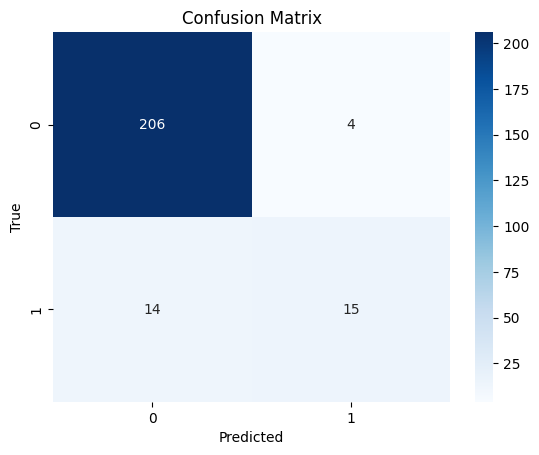

In [ ]:
# Train and evaluate Baseline RandomForestClassifier
baseline_clf = RandomForestClassifier(random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_base = baseline_clf.predict(X_test)
y_proba_base = baseline_clf.predict_proba(X_test)[:,1]

baseline_results = evaluate_model(y_test, y_pred_base, y_proba_base)
print("Baseline Metrics:", baseline_results)
print_report(y_test, y_pred_base)

## 4. Experiment: Imbalance Handling Techniques

We will now train and evaluate three different strategies to handle the imbalanced data and compare them against our baseline.

### 4.1. Technique 1: SMOTE (Oversampling)
SMOTE (Synthetic Minority Oversampling Technique) will create new "synthetic" samples for the minority class (1) in the training set to create a balanced dataset. We will use `imblearn.pipeline` to ensure SMOTE is only applied during training.

SMOTE Metrics: {'Accuracy': np.float64(0.8828451882845189), 'Precision': 0.5116279069767442, 'Recall': 0.7586206896551724, 'F1-Score': 0.6111111111111112, 'AUC': np.float64(0.9171592775041051)}
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       210
           1       0.51      0.76      0.61        29

    accuracy                           0.88       239
   macro avg       0.74      0.83      0.77       239
weighted avg       0.91      0.88      0.89       239



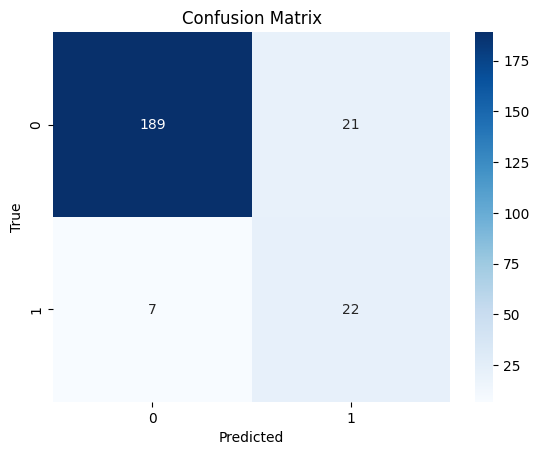

In [ ]:
# Train and evaluate RandomForestClassifier with SMOTE
smote_pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

smote_pipe.fit(X_train, y_train)
y_pred_smote = smote_pipe.predict(X_test)
y_proba_smote = smote_pipe.predict_proba(X_test)[:,1]

smote_results = evaluate_model(y_test, y_pred_smote, y_proba_smote)
print("SMOTE Metrics:", smote_results)
print_report(y_test, y_pred_smote)

### 4.2. Technique 2: Class Weight Balancing
This technique does not change the data. Instead, it modifies the model's learning algorithm to "penalize" mistakes on the minority class more heavily. We can do this by setting `class_weight='balanced'`.

Class Weight Metrics: {'Accuracy': np.float64(0.9205020920502092), 'Precision': 0.8125, 'Recall': 0.4482758620689655, 'F1-Score': 0.5777777777777777, 'AUC': np.float64(0.911904761904762)}
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       210
           1       0.81      0.45      0.58        29

    accuracy                           0.92       239
   macro avg       0.87      0.72      0.77       239
weighted avg       0.91      0.92      0.91       239



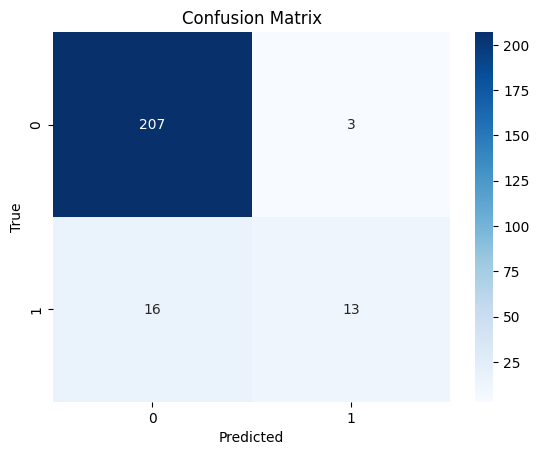

In [ ]:
# Train and evaluate RandomForestClassifier with Class Weight
cw_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
cw_clf.fit(X_train, y_train)
y_pred_cw = cw_clf.predict(X_test)
y_proba_cw = cw_clf.predict_proba(X_test)[:,1]

cw_results = evaluate_model(y_test, y_pred_cw, y_proba_cw)
print("Class Weight Metrics:", cw_results)
print_report(y_test, y_pred_cw)

### 4.3. Technique 3: Random Undersampling
This technique balances the dataset by randomly removing samples from the majority class (0). This is a simple but often effective method, though it risks losing important information from the majority class.

Undersampling Metrics: {'Accuracy': np.float64(0.8158995815899581), 'Precision': 0.3880597014925373, 'Recall': 0.896551724137931, 'F1-Score': 0.5416666666666666, 'AUC': np.float64(0.9041050903119869)}
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       210
           1       0.39      0.90      0.54        29

    accuracy                           0.82       239
   macro avg       0.69      0.85      0.71       239
weighted avg       0.91      0.82      0.84       239



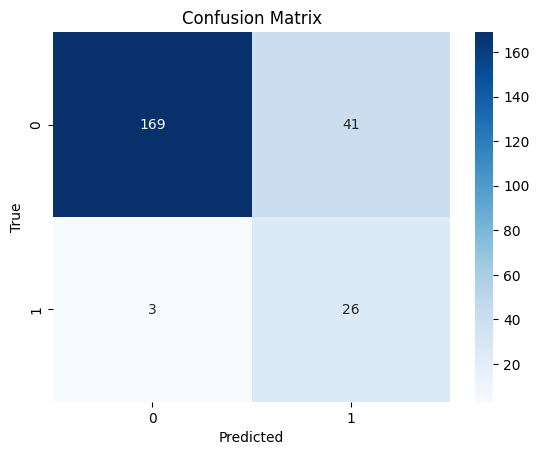

In [ ]:
# Train and evaluate RandomForestClassifier with Random Undersampling
under_pipe = Pipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

under_pipe.fit(X_train, y_train)
y_pred_under = under_pipe.predict(X_test)
y_proba_under = under_pipe.predict_proba(X_test)[:,1]

under_results = evaluate_model(y_test, y_pred_under, y_proba_under)
print("Undersampling Metrics:", under_results)
print_report(y_test, y_pred_under)

## 5. Model Comparison and Analysis

Let's aggregate the results from all RandomForest experiments into a single DataFrame to compare their performance.

In [ ]:
# Aggregate RandomForest Results
results_df = pd.DataFrame([baseline_results, smote_results, cw_results, under_results],
                          index=['Baseline', 'SMOTE', 'ClassWeight', 'Undersampling'])
results_df

,Accuracy,Precision,Recall,F1-Score,AUC
Baseline,0.924686,0.789474,0.517241,0.625000,0.911658
SMOTE,0.882845,0.511628,0.758621,0.611111,0.917159
ClassWeight,0.920502,0.812500,0.448276,0.577778,0.911905
Undersampling,0.815900,0.388060,0.896552,0.541667,0.904105


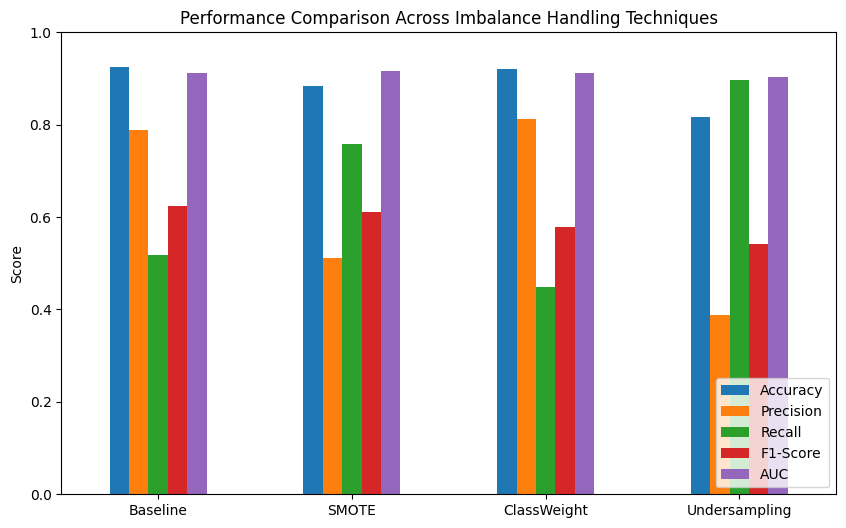

In [ ]:
# Visualize RandomForest Results
results_df.plot(kind='bar', figsize=(10,6))
plt.title("Performance Comparison Across Imbalance Handling Techniques")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

###  Analysis of Metrics

The results table shows a clear trade-off between different techniques:

| Technique | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | AUC |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Baseline** | **0.925** | 0.789 | 0.517 | **0.625** | 0.912 |
| **SMOTE** | 0.883 | 0.512 | 0.759 | 0.611 | **0.917** |
| **ClassWeight** | 0.921 | **0.813** | 0.448 | 0.578 | 0.912 |
| **Undersampling**| 0.816 | 0.388 | **0.897** | 0.542 | 0.904 |

**Key Observations:**

* **AUC:** **SMOTE** achieves the highest AUC (0.917), indicating the best overall ability to distinguish between "good" and "not good" wines.
* **Recall:** **Random Undersampling** provides a massive boost to Recall (0.897), meaning it successfully identifies almost 90% of all "good" wines.
* **Precision:** The high recall from Undersampling comes at a severe cost to Precision (0.388). Conversely, **Class Weighting** gives the best Precision (0.813), meaning its "good" predictions are highly reliable, but it misses many "good" wines (low Recall).
* **F1-Score:** The **Baseline** model (0.625) provides the best balance between Precision and Recall, narrowly beating SMOTE (0.611).

**Conclusion:** No single model is "best." The optimal choice depends on the goal:
* **If the goal is to find *all* good wines (e.g., for quality control), `Undersampling` is best (Highest Recall).**
* **If the goal is to be *sure* a wine is good (e.g., for premium labeling), `Class Weight` is best (Highest Precision).**
* **If the goal is the best *overall classification power*, `SMOTE` is the winner (Highest AUC).**

## 6. Comparative Analysis with Logistic Regression

To validate our findings, we will repeat the exact same imbalance handling experiments using a simpler, linear model: **Logistic Regression**.

This will help us understand two things:
1.  Is `RandomForest` a better model choice for this dataset overall?
2.  Does the effectiveness of these handling techniques (SMOTE, Class Weight, etc.) apply to linear models as well, or only to tree-based models?

We will test the same four scenarios:
* **Logistic_Baseline:** Standard Logistic Regression on the original data.
* **Logistic_SMOTE:** Trained on SMOTE-balanced data.
* **Logistic_ClassWeight:** Uses the `class_weight='balanced'` parameter.
* **Logistic_Undersampling:** Trained on the under-sampled data.

In [ ]:
# Define evaluation function for Logistic Regression
def evaluate_model(y_true, y_pred, y_prob, model_name):
    """Compute evaluation metrics and return as a dictionary."""
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_true, y_prob)
    }

In [ ]:
# Train and evaluate Logistic Regression models with different imbalance handling techniques
results = []
# Initialize logistic model
log_base = LogisticRegression(max_iter=1000, random_state=42)
log_weight = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Baseline
log_base.fit(X_train, y_train)
y_pred_log_base = log_base.predict(X_test)
y_prob_log_base = log_base.predict_proba(X_test)[:,1]
results.append(evaluate_model(y_test, y_pred_log_base, y_prob_log_base, 'Logistic_Baseline'))

# SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
log_smote = LogisticRegression(max_iter=1000, random_state=42)
log_smote.fit(X_train_sm, y_train_sm)
y_pred_log_sm = log_smote.predict(X_test)
y_prob_log_sm = log_smote.predict_proba(X_test)[:,1]
results.append(evaluate_model(y_test, y_pred_log_sm, y_prob_log_sm, 'Logistic_SMOTE'))

# Class Weight
log_weight.fit(X_train, y_train)
y_pred_log_weight = log_weight.predict(X_test)
y_prob_log_weight = log_weight.predict_proba(X_test)[:,1]
results.append(evaluate_model(y_test, y_pred_log_weight, y_prob_log_weight, 'Logistic_ClassWeight'))

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
log_under = LogisticRegression(max_iter=1000, random_state=42)
log_under.fit(X_train_under, y_train_under)
y_pred_log_under = log_under.predict(X_test)
y_prob_log_under = log_under.predict_proba(X_test)[:,1]
results.append(evaluate_model(y_test, y_pred_log_under, y_prob_log_under, 'Logistic_Undersampling'))

In [ ]:
# Display Logistic Regression Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AUC', ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Logistic_Baseline,0.891213,0.588235,0.344828,0.434783,0.855337
1,Logistic_ClassWeight,0.753138,0.307692,0.827586,0.448598,0.849918
2,Logistic_SMOTE,0.753138,0.302632,0.793103,0.438095,0.848440
3,Logistic_Undersampling,0.761506,0.315789,0.827586,0.457143,0.843842


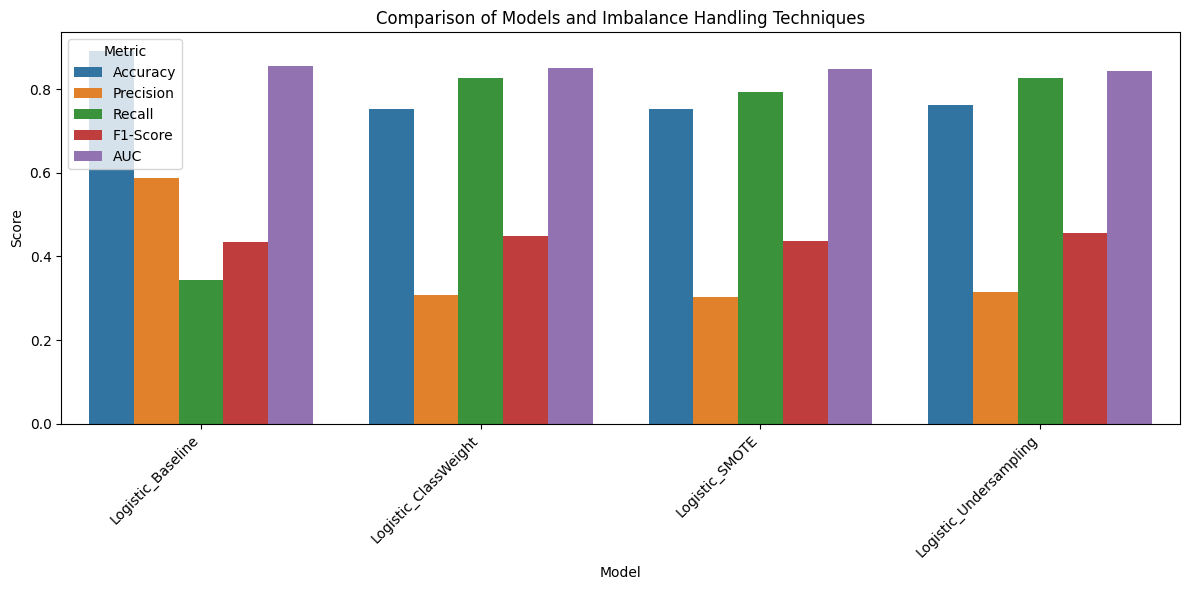

In [ ]:
# Visualize Logistic Regression Results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

plt.figure(figsize=(12,6))
sns.barplot(data=results_df.melt(id_vars='Model', value_vars=metrics),
            x='Model', y='value', hue='variable')
plt.xticks(rotation=45, ha='right')
plt.title('Comparison of Models and Imbalance Handling Techniques')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

### Logistic Regression Results Analysis

The results from the Logistic Regression experiments show a completely different story:

| Model | Accuracy | Precision | Recall | F1-Score | AUC |
| :--- | :---: | :---: | :---: | :---: | :---: |
| Logistic_Baseline | **0.891** | **0.588** | 0.345 | 0.435 | **0.855** |
| Logistic_ClassWeight| 0.753 | 0.308 | 0.828 | 0.449 | 0.850 |
| Logistic_SMOTE | 0.753 | 0.303 | 0.793 | 0.438 | 0.848 |
| Logistic_Undersampling| 0.762 | 0.316 | **0.828** | **0.457** | 0.844 |
*

**Key Observations:**

1.  **Baseline is Strongest:** For Logistic Regression, the `Logistic_Baseline` model (AUC 0.855) provides the best overall performance, unlike in the RandomForest experiment.
2.  **Techniques Reduce AUC:** All three handling techniques (SMOTE, ClassWeight, Undersampling) actually *decreased* the model's overall discriminative power (AUC).
3.  **Severe Trade-off:** While `ClassWeight` and `Undersampling` did successfully increase Recall to ~0.83, it came at a massive cost to Precision (dropping from 0.588 to ~0.31). This resulted in a very low F1-Score.

**Conclusion:** This proves that imbalance handling techniques are not universally beneficial. The linear model (Logistic Regression) seems to perform better on the original, imbalanced data, and the resampling techniques may have introduced noise or patterns that it could not effectively model.

## 7. Final Conclusion

1.  **Model Selection:** `RandomForest` (Baseline AUC: 0.912) proved to be a much stronger model for this dataset than `Logistic Regression` (Baseline AUC: 0.855).
2.  **Technique Effectiveness:** For the superior `RandomForest` model, **SMOTE** appears to be the most promising technique. It slightly increased the AUC to **0.917** (the highest of all models) and significantly improved Recall (from 0.517 to 0.759) while maintaining a reasonable F1-Score.
3.  **Recommendation:** For a balanced and robust model, the **SMOTE + RandomForest** pipeline is the recommended choice.